In [1]:
from dataset_test import METRLADatasetLoader;

In [2]:
loader = METRLADatasetLoader();

dataset = loader.get_dataset(num_timesteps_in = 12, num_timesteps_out = 12);

from torch_geometric_temporal.signal import temporal_signal_split
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.8)

import torch
import torch.nn.functional as F
from torch_geometric_temporal.nn.recurrent import A3TGCN

14188608


In [3]:
train_dataset[0].x

tensor([[[ 0.5332,  0.4486,  0.5146,  ...,  0.4899,  0.5751,  0.4280],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.6940,  0.7400,  0.5022,  ...,  0.3909,  0.4981,  0.7002],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.6692,  0.5861,  0.3167,  ...,  0.4404,  0.5696,  0.6569],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        ...,

        [[ 0.2796,  0.1133,  0.3847,  ..., -0.1410,  0.3442,  0.1683],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.7620,  0.7345,  0.8044,  ...,  0.6259,  0.6741,  0.6383],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]],

        [[ 0.4095,  0.4590,  0.4157,  ...,  0.4280,  0.3167,  0.2884],
         [-1.7292, -1.7171, -1.7051,  ..., -1.6207, -1.6087, -1.5966]]])

In [56]:
train_dataset[1].y[0]

tensor([ 0.2452,  0.4961,  0.6521,  0.1126,  0.5311,  0.5091,  0.4713,  0.4218,
         0.3909,  0.4761,  0.5641, -0.0022])

In [59]:
class TemporalGNN(torch.nn.Module):
    def __init__(self, node_features, periods):
        super(TemporalGNN, self).__init__()
        # Attention Temporal Graph Convolutional Cell
        self.tgnn = A3TGCN(in_channels=node_features,
                           out_channels=32,
                           periods=periods)
        # Equals single-shot prediction
        self.linear = torch.nn.Linear(32, periods)

    def forward(self, x, edge_index):
        """
        x = Node features for T time steps
        edge_index = Graph edge indices
        """
        h = self.tgnn(x, edge_index)
        print(h)
        h = F.relu(h)
        print(h)
        h = self.linear(h)
        print(h)
        return h

TemporalGNN(node_features=2, periods=12)

# GPU support
device = torch.device('cpu') # cuda
subset = 50


In [60]:
model = TemporalGNN(node_features=2, periods=12).to(device)
model.parameters

<bound method Module.parameters of TemporalGNN(
  (tgnn): A3TGCN(
    (_base_tgcn): TGCN(
      (conv_z): GCNConv(2, 32)
      (linear_z): Linear(in_features=64, out_features=32, bias=True)
      (conv_r): GCNConv(2, 32)
      (linear_r): Linear(in_features=64, out_features=32, bias=True)
      (conv_h): GCNConv(2, 32)
      (linear_h): Linear(in_features=64, out_features=32, bias=True)
    )
  )
  (linear): Linear(in_features=32, out_features=12, bias=True)
)>

In [61]:
train_dataset[0]

Data(x=[207, 2, 12], edge_index=[2, 1722], edge_attr=[1722], y=[207, 12])

In [62]:
train_dataset[0].x[0]

tensor([[ 0.5332,  0.4486,  0.5146, -2.6522, -2.6522,  0.1847,  0.6383,  0.4961,
          0.7497,  0.4899,  0.5751,  0.4280],
        [-1.7292, -1.7171, -1.7051, -1.6930, -1.6810, -1.6689, -1.6569, -1.6448,
         -1.6328, -1.6207, -1.6087, -1.5966]])

In [63]:
device

device(type='cpu')

In [65]:

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

print("Running training...")
for epoch in range(30):
    loss = 0
    step = 0
    for snapshot in train_dataset:
        snapshot = snapshot.to(device)
    
        # Get model predictions
        y_hat = model(snapshot.x, snapshot.edge_index)
        print(y_hat.shape)
        # Mean squared error
        loss = loss + torch.mean((y_hat-snapshot.y)**2)
        step += 1
        if step > subset:
          break

    loss = loss / (step + 1)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print("Epoch {} train MSE: {:.4f}".format(epoch, loss.item()))

Running training...
tensor([[-0.2912, -0.1908,  0.5055,  ..., -0.1888, -0.0893, -0.2903],
        [-0.3249, -0.1960,  0.5419,  ..., -0.1886, -0.0908, -0.3135],
        [-0.2669, -0.1788,  0.4926,  ..., -0.1789, -0.0721, -0.2451],
        ...,
        [-0.2318, -0.1734,  0.4295,  ..., -0.1856, -0.0944, -0.2616],
        [-0.2928, -0.1885,  0.5153,  ..., -0.1844, -0.0807, -0.2751],
        [-0.2784, -0.1836,  0.5028,  ..., -0.1816, -0.0760, -0.2586]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5055,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5419,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4926,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4295,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5153,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5028,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3166, 0.2896, 0.2345,  ..., 0.3090, 0.3885, 0.2994],
        [0.3469, 0.32

tensor([[-0.2949, -0.2235,  0.5274,  ..., -0.2048, -0.0328, -0.2693],
        [-0.3554, -0.2388,  0.6078,  ..., -0.2035, -0.0143, -0.2876],
        [-0.2935, -0.2107,  0.5575,  ..., -0.1893, -0.0116, -0.2177],
        ...,
        [-0.2457, -0.2003,  0.4693,  ..., -0.1958, -0.0401, -0.2381],
        [-0.3011, -0.2219,  0.5488,  ..., -0.1998, -0.0221, -0.2528],
        [-0.2973, -0.2157,  0.5542,  ..., -0.1939, -0.0161, -0.2334]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5274,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6078,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5575,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4693,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5488,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5542,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3369, 0.3108, 0.2569,  ..., 0.3230, 0.4120, 0.3160],
        [0.4141, 0.3877, 0.3101,  ..., 0.

tensor([[-0.2612, -0.2048,  0.4961,  ..., -0.1949, -0.0320, -0.2354],
        [-0.3338, -0.2269,  0.5996,  ..., -0.1950, -0.0083, -0.2463],
        [-0.2748, -0.1961,  0.5486,  ..., -0.1793, -0.0047, -0.1840],
        ...,
        [-0.1847, -0.1634,  0.3723,  ..., -0.1816, -0.0614, -0.2166],
        [-0.2614, -0.2013,  0.5055,  ..., -0.1905, -0.0252, -0.2216],
        [-0.2496, -0.1925,  0.4955,  ..., -0.1852, -0.0233, -0.2064]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4961,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5996,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5486,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3723,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5055,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4955,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3177, 0.2907, 0.2442,  ..., 0.3155, 0.3815, 0.2998],
        [0.4170, 0.3896, 0.3138,  ..., 0.

tensor([[-0.2419, -0.1856,  0.4912,  ..., -0.1805, -0.0203, -0.1926],
        [-0.2982, -0.2081,  0.5728,  ..., -0.1847, -0.0044, -0.2026],
        [-0.2443, -0.1750,  0.5200,  ..., -0.1676, -0.0007, -0.1499],
        ...,
        [-0.1843, -0.1510,  0.3988,  ..., -0.1675, -0.0370, -0.1750],
        [-0.2360, -0.1800,  0.4876,  ..., -0.1766, -0.0178, -0.1820],
        [-0.2410, -0.1774,  0.5066,  ..., -0.1716, -0.0078, -0.1642]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4912,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5728,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5200,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3988,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4876,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5066,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3293, 0.3005, 0.2533,  ..., 0.3295, 0.3836, 0.3095],
        [0.4020, 0.3736, 0.3043,  ..., 0.

tensor([[-0.2581, -0.2235,  0.4999,  ..., -0.1997,  0.0013, -0.2605],
        [-0.3335, -0.2421,  0.6140,  ..., -0.1981,  0.0247, -0.2749],
        [-0.2776, -0.2085,  0.5611,  ..., -0.1831,  0.0265, -0.2067],
        ...,
        [-0.2174, -0.1994,  0.4479,  ..., -0.1884, -0.0043, -0.2287],
        [-0.2835, -0.2222,  0.5532,  ..., -0.1929,  0.0182, -0.2406],
        [-0.2751, -0.2138,  0.5488,  ..., -0.1879,  0.0206, -0.2231]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4999,  ..., 0.0000, 0.0013, 0.0000],
        [0.0000, 0.0000, 0.6140,  ..., 0.0000, 0.0247, 0.0000],
        [0.0000, 0.0000, 0.5611,  ..., 0.0000, 0.0265, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4479,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5532,  ..., 0.0000, 0.0182, 0.0000],
        [0.0000, 0.0000, 0.5488,  ..., 0.0000, 0.0206, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2412, 0.2723, 0.2695,  ..., 0.2622, 0.3041, 0.2866],
        [0.3418, 0.3983, 0.3610,  ..., 0.

tensor([[-0.2369, -0.2034,  0.4848,  ..., -0.1876,  0.0060, -0.2240],
        [-0.3110, -0.2258,  0.5993,  ..., -0.1894,  0.0286, -0.2341],
        [-0.2597, -0.1904,  0.5488,  ..., -0.1730,  0.0310, -0.1733],
        ...,
        [-0.1409, -0.1611,  0.3128,  ..., -0.1717, -0.0368, -0.2098],
        [-0.2343, -0.1974,  0.4867,  ..., -0.1834,  0.0093, -0.2116],
        [-0.2253, -0.1882,  0.4793,  ..., -0.1781,  0.0112, -0.1966]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4848,  ..., 0.0000, 0.0060, 0.0000],
        [0.0000, 0.0000, 0.5993,  ..., 0.0000, 0.0286, 0.0000],
        [0.0000, 0.0000, 0.5488,  ..., 0.0000, 0.0310, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3128,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4867,  ..., 0.0000, 0.0093, 0.0000],
        [0.0000, 0.0000, 0.4793,  ..., 0.0000, 0.0112, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2447, 0.2731, 0.2702,  ..., 0.2705, 0.2973, 0.2876],
        [0.3425, 0.3964, 0.3600,  ..., 0.

Epoch 1 train MSE: 0.1878
tensor([[-0.2531, -0.2300,  0.5340,  ..., -0.1791, -0.0259, -0.2803],
        [-0.2864, -0.2421,  0.5785,  ..., -0.1786, -0.0280, -0.3029],
        [-0.2355, -0.2082,  0.5213,  ..., -0.1702, -0.0109, -0.2350],
        ...,
        [-0.1888, -0.2062,  0.4376,  ..., -0.1760, -0.0325, -0.2528],
        [-0.2581, -0.2248,  0.5474,  ..., -0.1751, -0.0183, -0.2648],
        [-0.2455, -0.2159,  0.5331,  ..., -0.1727, -0.0142, -0.2484]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5340,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5785,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5213,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4376,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5474,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5331,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2880, 0.3424, 0.3329,  ..., 0.3021, 0.3120, 0.3541],
        [0.3271

tensor([[-0.2516, -0.2279,  0.5171,  ..., -0.1973,  0.0344, -0.2539],
        [-0.3322, -0.2466,  0.6433,  ..., -0.1956,  0.0579, -0.2670],
        [-0.2796, -0.2100,  0.5875,  ..., -0.1812,  0.0580, -0.1992],
        ...,
        [-0.2100, -0.2036,  0.4606,  ..., -0.1862,  0.0270, -0.2225],
        [-0.2822, -0.2254,  0.5776,  ..., -0.1907,  0.0508, -0.2332],
        [-0.2750, -0.2163,  0.5733,  ..., -0.1858,  0.0527, -0.2158]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5171,  ..., 0.0000, 0.0344, 0.0000],
        [0.0000, 0.0000, 0.6433,  ..., 0.0000, 0.0579, 0.0000],
        [0.0000, 0.0000, 0.5875,  ..., 0.0000, 0.0580, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4606,  ..., 0.0000, 0.0270, 0.0000],
        [0.0000, 0.0000, 0.5776,  ..., 0.0000, 0.0508, 0.0000],
        [0.0000, 0.0000, 0.5733,  ..., 0.0000, 0.0527, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2662, 0.3271, 0.3223,  ..., 0.2886, 0.2929, 0.3326],
        [0.3825, 0.4751, 0.4324,  ..., 0.

tensor([[-0.2294, -0.2051,  0.4972,  ..., -0.1849,  0.0367, -0.2158],
        [-0.3076, -0.2270,  0.6214,  ..., -0.1873,  0.0602, -0.2247],
        [-0.2610, -0.1889,  0.5708,  ..., -0.1709,  0.0605, -0.1647],
        ...,
        [-0.1202, -0.1667,  0.3019,  ..., -0.1683, -0.0110, -0.2035],
        [-0.2267, -0.1984,  0.4979,  ..., -0.1808,  0.0390, -0.2037],
        [-0.2242, -0.1896,  0.5005,  ..., -0.1756,  0.0425, -0.1875]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4972,  ..., 0.0000, 0.0367, 0.0000],
        [0.0000, 0.0000, 0.6214,  ..., 0.0000, 0.0602, 0.0000],
        [0.0000, 0.0000, 0.5708,  ..., 0.0000, 0.0605, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3019,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4979,  ..., 0.0000, 0.0390, 0.0000],
        [0.0000, 0.0000, 0.5005,  ..., 0.0000, 0.0425, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2670, 0.3229, 0.3193,  ..., 0.2951, 0.2837, 0.3300],
        [0.3696, 0.4581, 0.4175,  ..., 0.

Epoch 2 train MSE: 0.1862
tensor([[-0.2402, -0.2415,  0.5386,  ..., -0.1765, -0.0429, -0.2820],
        [-0.2733, -0.2549,  0.5862,  ..., -0.1758, -0.0443, -0.3046],
        [-0.2255, -0.2175,  0.5274,  ..., -0.1680, -0.0265, -0.2364],
        ...,
        [-0.1727, -0.2166,  0.4336,  ..., -0.1735, -0.0509, -0.2545],
        [-0.2467, -0.2356,  0.5541,  ..., -0.1727, -0.0345, -0.2663],
        [-0.2349, -0.2259,  0.5394,  ..., -0.1704, -0.0301, -0.2498]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5386,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5862,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5274,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4336,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5541,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5394,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3080, 0.3440, 0.3461,  ..., 0.3176, 0.2994, 0.3460],
        [0.3530

tensor([[-0.2424, -0.2320,  0.5118,  ..., -0.1951,  0.0189, -0.2534],
        [-0.3283, -0.2509,  0.6506,  ..., -0.1938,  0.0453, -0.2663],
        [-0.2773, -0.2115,  0.5897,  ..., -0.1796,  0.0462, -0.1989],
        ...,
        [-0.2014, -0.2074,  0.4538,  ..., -0.1840,  0.0127, -0.2220],
        [-0.2782, -0.2284,  0.5798,  ..., -0.1889,  0.0378, -0.2326],
        [-0.2681, -0.2182,  0.5690,  ..., -0.1843,  0.0389, -0.2161]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5118,  ..., 0.0000, 0.0189, 0.0000],
        [0.0000, 0.0000, 0.6506,  ..., 0.0000, 0.0453, 0.0000],
        [0.0000, 0.0000, 0.5897,  ..., 0.0000, 0.0462, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4538,  ..., 0.0000, 0.0127, 0.0000],
        [0.0000, 0.0000, 0.5798,  ..., 0.0000, 0.0378, 0.0000],
        [0.0000, 0.0000, 0.5690,  ..., 0.0000, 0.0389, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2792, 0.3148, 0.3255,  ..., 0.2981, 0.2714, 0.3165],
        [0.4222, 0.4883, 0.4618,  ..., 0.

tensor([[-0.2226, -0.2092,  0.4920,  ..., -0.1835,  0.0225, -0.2173],
        [-0.3063, -0.2306,  0.6278,  ..., -0.1861,  0.0481, -0.2261],
        [-0.2633, -0.1902,  0.5770,  ..., -0.1699,  0.0504, -0.1657],
        ...,
        [-0.0998, -0.1738,  0.2771,  ..., -0.1664, -0.0284, -0.2052],
        [-0.2212, -0.2021,  0.4938,  ..., -0.1795,  0.0255, -0.2051],
        [-0.2205, -0.1927,  0.4981,  ..., -0.1744,  0.0300, -0.1889]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4920,  ..., 0.0000, 0.0225, 0.0000],
        [0.0000, 0.0000, 0.6278,  ..., 0.0000, 0.0481, 0.0000],
        [0.0000, 0.0000, 0.5770,  ..., 0.0000, 0.0504, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2771,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4938,  ..., 0.0000, 0.0255, 0.0000],
        [0.0000, 0.0000, 0.4981,  ..., 0.0000, 0.0300, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2802, 0.3119, 0.3236,  ..., 0.3052, 0.2641, 0.3156],
        [0.4088, 0.4713, 0.4469,  ..., 0.

tensor([[-0.2186, -0.1915,  0.4953,  ..., -0.1739,  0.0296, -0.1875],
        [-0.2916, -0.2129,  0.6136,  ..., -0.1786,  0.0511, -0.1951],
        [-0.2445, -0.1719,  0.5524,  ..., -0.1621,  0.0506, -0.1430],
        ...,
        [-0.1428, -0.1618,  0.3652,  ..., -0.1598,  0.0042, -0.1713],
        [-0.2216, -0.1851,  0.5041,  ..., -0.1701,  0.0341, -0.1754],
        [-0.2324, -0.1775,  0.5280,  ..., -0.1657,  0.0428, -0.1580]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4953,  ..., 0.0000, 0.0296, 0.0000],
        [0.0000, 0.0000, 0.6136,  ..., 0.0000, 0.0511, 0.0000],
        [0.0000, 0.0000, 0.5524,  ..., 0.0000, 0.0506, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3652,  ..., 0.0000, 0.0042, 0.0000],
        [0.0000, 0.0000, 0.5041,  ..., 0.0000, 0.0341, 0.0000],
        [0.0000, 0.0000, 0.5280,  ..., 0.0000, 0.0428, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3007, 0.3337, 0.3409,  ..., 0.3250, 0.2774, 0.3345],
        [0.4005, 0.4611, 0.4371,  ..., 0.

tensor([[-0.2286, -0.2374,  0.4904,  ..., -0.1941, -0.0062, -0.2600],
        [-0.3193, -0.2563,  0.6428,  ..., -0.1931,  0.0237, -0.2733],
        [-0.2741, -0.2154,  0.5850,  ..., -0.1787,  0.0271, -0.2045],
        ...,
        [-0.1861, -0.2127,  0.4271,  ..., -0.1828, -0.0124, -0.2283],
        [-0.2701, -0.2331,  0.5683,  ..., -0.1880,  0.0159, -0.2390],
        [-0.2654, -0.2229,  0.5656,  ..., -0.1832,  0.0194, -0.2214]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4904,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6428,  ..., 0.0000, 0.0237, 0.0000],
        [0.0000, 0.0000, 0.5850,  ..., 0.0000, 0.0271, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4271,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5683,  ..., 0.0000, 0.0159, 0.0000],
        [0.0000, 0.0000, 0.5656,  ..., 0.0000, 0.0194, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2716, 0.2703, 0.2946,  ..., 0.2861, 0.2449, 0.2732],
        [0.4375, 0.4608, 0.4492,  ..., 0.

tensor([[-0.2150, -0.2146,  0.4787,  ..., -0.1825,  0.0007, -0.2231],
        [-0.3047, -0.2355,  0.6291,  ..., -0.1849,  0.0293, -0.2319],
        [-0.2639, -0.1933,  0.5765,  ..., -0.1692,  0.0336, -0.1706],
        ...,
        [-0.0809, -0.1818,  0.2474,  ..., -0.1652, -0.0527, -0.2104],
        [-0.2163, -0.2073,  0.4846,  ..., -0.1785,  0.0052, -0.2104],
        [-0.2106, -0.1968,  0.4791,  ..., -0.1734,  0.0081, -0.1952]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4787,  ..., 0.0000, 0.0007, 0.0000],
        [0.0000, 0.0000, 0.6291,  ..., 0.0000, 0.0293, 0.0000],
        [0.0000, 0.0000, 0.5765,  ..., 0.0000, 0.0336, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2474,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4846,  ..., 0.0000, 0.0052, 0.0000],
        [0.0000, 0.0000, 0.4791,  ..., 0.0000, 0.0081, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2841, 0.2796, 0.3037,  ..., 0.3018, 0.2478, 0.2841],
        [0.4437, 0.4652, 0.4534,  ..., 0.

Epoch 4 train MSE: 0.1827
tensor([[-0.2019, -0.2558,  0.5260,  ..., -0.1710, -0.0736, -0.2891],
        [-0.2346, -0.2700,  0.5803,  ..., -0.1701, -0.0725, -0.3118],
        [-0.1937, -0.2300,  0.5203,  ..., -0.1631, -0.0549, -0.2430],
        ...,
        [-0.1289, -0.2308,  0.4031,  ..., -0.1680, -0.0860, -0.2615],
        [-0.2116, -0.2494,  0.5470,  ..., -0.1674, -0.0634, -0.2733],
        [-0.2016, -0.2390,  0.5322,  ..., -0.1653, -0.0588, -0.2566]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5260,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5803,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5203,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4031,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5470,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5322,  ..., 0.0000, 0.0000, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3277, 0.3108, 0.3185,  ..., 0.3200, 0.2934, 0.3043],
        [0.3844

tensor([[-0.2073, -0.2425,  0.4731,  ..., -0.1927, -0.0138, -0.2652],
        [-0.3028, -0.2612,  0.6380,  ..., -0.1923,  0.0192, -0.2789],
        [-0.2634, -0.2190,  0.5838,  ..., -0.1778,  0.0245, -0.2086],
        ...,
        [-0.1715, -0.2181,  0.4180,  ..., -0.1816, -0.0172, -0.2322],
        [-0.2570, -0.2376,  0.5649,  ..., -0.1869,  0.0122, -0.2436],
        [-0.2532, -0.2271,  0.5623,  ..., -0.1822,  0.0160, -0.2258]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4731,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6380,  ..., 0.0000, 0.0192, 0.0000],
        [0.0000, 0.0000, 0.5838,  ..., 0.0000, 0.0245, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4180,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5649,  ..., 0.0000, 0.0122, 0.0000],
        [0.0000, 0.0000, 0.5623,  ..., 0.0000, 0.0160, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2690, 0.2455, 0.2684,  ..., 0.2755, 0.2367, 0.2499],
        [0.4577, 0.4536, 0.4397,  ..., 0.

tensor([[-0.1912, -0.2205,  0.4527,  ..., -0.1822, -0.0092, -0.2312],
        [-0.2973, -0.2414,  0.6371,  ..., -0.1841,  0.0276, -0.2383],
        [-0.2568, -0.1975,  0.5787,  ..., -0.1690,  0.0319, -0.1763],
        ...,
        [-0.0568, -0.1903,  0.2225,  ..., -0.1647, -0.0623, -0.2165],
        [-0.2066, -0.2136,  0.4827,  ..., -0.1783,  0.0017, -0.2164],
        [-0.2012, -0.2028,  0.4764,  ..., -0.1732,  0.0047, -0.2009]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4527,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6371,  ..., 0.0000, 0.0276, 0.0000],
        [0.0000, 0.0000, 0.5787,  ..., 0.0000, 0.0319, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2225,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4827,  ..., 0.0000, 0.0017, 0.0000],
        [0.0000, 0.0000, 0.4764,  ..., 0.0000, 0.0047, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2709, 0.2438, 0.2689,  ..., 0.2836, 0.2309, 0.2520],
        [0.4817, 0.4777, 0.4607,  ..., 0.

tensor([[-0.2069, -0.1947,  0.4892,  ..., -0.1694,  0.0113, -0.1871],
        [-0.2763, -0.2141,  0.6087,  ..., -0.1747,  0.0323, -0.1962],
        [-0.2376, -0.1708,  0.5507,  ..., -0.1585,  0.0358, -0.1436],
        ...,
        [-0.1279, -0.1678,  0.3508,  ..., -0.1559, -0.0135, -0.1706],
        [-0.2046, -0.1870,  0.4869,  ..., -0.1659,  0.0137, -0.1765],
        [-0.2223, -0.1780,  0.5215,  ..., -0.1618,  0.0260, -0.1586]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4892,  ..., 0.0000, 0.0113, 0.0000],
        [0.0000, 0.0000, 0.6087,  ..., 0.0000, 0.0323, 0.0000],
        [0.0000, 0.0000, 0.5507,  ..., 0.0000, 0.0358, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3508,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4869,  ..., 0.0000, 0.0137, 0.0000],
        [0.0000, 0.0000, 0.5215,  ..., 0.0000, 0.0260, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3439, 0.3208, 0.3346,  ..., 0.3462, 0.2872, 0.3183],
        [0.4724, 0.4656, 0.4522,  ..., 0.

tensor([[-0.1834, -0.2457,  0.4699,  ..., -0.1910, -0.0063, -0.2656],
        [-0.2850, -0.2643,  0.6467,  ..., -0.1907,  0.0293, -0.2787],
        [-0.2501, -0.2208,  0.5935,  ..., -0.1765,  0.0354, -0.2080],
        ...,
        [-0.1494, -0.2213,  0.4139,  ..., -0.1801, -0.0099, -0.2324],
        [-0.2401, -0.2402,  0.5711,  ..., -0.1854,  0.0220, -0.2434],
        [-0.2377, -0.2294,  0.5694,  ..., -0.1808,  0.0261, -0.2254]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4699,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6467,  ..., 0.0000, 0.0293, 0.0000],
        [0.0000, 0.0000, 0.5935,  ..., 0.0000, 0.0354, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4139,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5711,  ..., 0.0000, 0.0220, 0.0000],
        [0.0000, 0.0000, 0.5694,  ..., 0.0000, 0.0261, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2854, 0.2510, 0.2656,  ..., 0.2800, 0.2537, 0.2583],
        [0.4997, 0.4860, 0.4575,  ..., 0.

tensor([[-0.1707, -0.2235,  0.4513,  ..., -0.1807, -0.0012, -0.2313],
        [-0.2825, -0.2438,  0.6478,  ..., -0.1827,  0.0386, -0.2378],
        [-0.2465, -0.1985,  0.5905,  ..., -0.1680,  0.0435, -0.1754],
        ...,
        [-0.0262, -0.1948,  0.2046,  ..., -0.1629, -0.0593, -0.2172],
        [-0.1892, -0.2162,  0.4850,  ..., -0.1769,  0.0107, -0.2162],
        [-0.1854, -0.2051,  0.4796,  ..., -0.1719,  0.0139, -0.2007]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4513,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6478,  ..., 0.0000, 0.0386, 0.0000],
        [0.0000, 0.0000, 0.5905,  ..., 0.0000, 0.0435, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2046,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4850,  ..., 0.0000, 0.0107, 0.0000],
        [0.0000, 0.0000, 0.4796,  ..., 0.0000, 0.0139, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2899,  0.2524,  0.2692,  ...,  0.2905,  0.2498,  0.2631],
        [ 0.5285,  0.5153,  0.4835,

tensor([[-0.1933, -0.1966,  0.4949,  ..., -0.1682,  0.0211, -0.1866],
        [-0.2645, -0.2155,  0.6205,  ..., -0.1735,  0.0438, -0.1953],
        [-0.2299, -0.1711,  0.5635,  ..., -0.1577,  0.0476, -0.1424],
        ...,
        [-0.1110, -0.1706,  0.3484,  ..., -0.1547, -0.0061, -0.1703],
        [-0.1920, -0.1887,  0.4935,  ..., -0.1648,  0.0238, -0.1758],
        [-0.2128, -0.1790,  0.5319,  ..., -0.1609,  0.0371, -0.1576]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4949,  ..., 0.0000, 0.0211, 0.0000],
        [0.0000, 0.0000, 0.6205,  ..., 0.0000, 0.0438, 0.0000],
        [0.0000, 0.0000, 0.5635,  ..., 0.0000, 0.0476, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3484,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4935,  ..., 0.0000, 0.0238, 0.0000],
        [0.0000, 0.0000, 0.5319,  ..., 0.0000, 0.0371, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3753, 0.3448, 0.3468,  ..., 0.3644, 0.3166, 0.3402],
        [0.5203, 0.5048, 0.4768,  ..., 0.

tensor([[-0.1605, -0.2484,  0.4686,  ..., -0.1893,  0.0080, -0.2658],
        [-0.2689, -0.2669,  0.6560,  ..., -0.1892,  0.0463, -0.2784],
        [-0.2388, -0.2222,  0.6046,  ..., -0.1753,  0.0529, -0.2072],
        ...,
        [-0.1284, -0.2239,  0.4124,  ..., -0.1786,  0.0040, -0.2325],
        [-0.2249, -0.2423,  0.5788,  ..., -0.1840,  0.0387, -0.2431],
        [-0.2242, -0.2312,  0.5782,  ..., -0.1795,  0.0430, -0.2249]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4686,  ..., 0.0000, 0.0080, 0.0000],
        [0.0000, 0.0000, 0.6560,  ..., 0.0000, 0.0463, 0.0000],
        [0.0000, 0.0000, 0.6046,  ..., 0.0000, 0.0529, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4124,  ..., 0.0000, 0.0040, 0.0000],
        [0.0000, 0.0000, 0.5788,  ..., 0.0000, 0.0387, 0.0000],
        [0.0000, 0.0000, 0.5782,  ..., 0.0000, 0.0430, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2925, 0.2595, 0.2663,  ..., 0.2793, 0.2732, 0.2702],
        [0.5312, 0.5226, 0.4798,  ..., 0.

tensor([[-0.1516, -0.2259,  0.4524,  ..., -0.1793,  0.0134, -0.2313],
        [-0.2694, -0.2456,  0.6593,  ..., -0.1814,  0.0563, -0.2370],
        [-0.2382, -0.1992,  0.6038,  ..., -0.1670,  0.0614, -0.1741],
        ...,
        [ 0.0049, -0.1987,  0.1903,  ..., -0.1612, -0.0503, -0.2177],
        [-0.1736, -0.2183,  0.4896,  ..., -0.1756,  0.0262, -0.2159],
        [-0.1712, -0.2070,  0.4852,  ..., -0.1707,  0.0294, -0.2002]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4524,  ..., 0.0000, 0.0134, 0.0000],
        [0.0000, 0.0000, 0.6593,  ..., 0.0000, 0.0563, 0.0000],
        [0.0000, 0.0000, 0.6038,  ..., 0.0000, 0.0614, 0.0000],
        ...,
        [0.0049, 0.0000, 0.1903,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4896,  ..., 0.0000, 0.0262, 0.0000],
        [0.0000, 0.0000, 0.4852,  ..., 0.0000, 0.0294, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.3001,  0.2660,  0.2735,  ...,  0.2930,  0.2721,  0.2780],
        [ 0.5661,  0.5580,  0.5112,

tensor([[-0.1815, -0.1981,  0.5031,  ..., -0.1671,  0.0372, -0.1858],
        [-0.2546, -0.2164,  0.6336,  ..., -0.1724,  0.0619, -0.1941],
        [-0.2242, -0.1710,  0.5783,  ..., -0.1569,  0.0655, -0.1409],
        ...,
        [-0.0953, -0.1729,  0.3493,  ..., -0.1536,  0.0072, -0.1699],
        [-0.1814, -0.1900,  0.5026,  ..., -0.1637,  0.0400, -0.1749],
        [-0.2052, -0.1796,  0.5445,  ..., -0.1600,  0.0543, -0.1564]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5031,  ..., 0.0000, 0.0372, 0.0000],
        [0.0000, 0.0000, 0.6336,  ..., 0.0000, 0.0619, 0.0000],
        [0.0000, 0.0000, 0.5783,  ..., 0.0000, 0.0655, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3493,  ..., 0.0000, 0.0072, 0.0000],
        [0.0000, 0.0000, 0.5026,  ..., 0.0000, 0.0400, 0.0000],
        [0.0000, 0.0000, 0.5445,  ..., 0.0000, 0.0543, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3999, 0.3741, 0.3641,  ..., 0.3797, 0.3504, 0.3677],
        [0.5599, 0.5498, 0.5067,  ..., 0.

tensor([[-0.1377, -0.2519,  0.4498,  ..., -0.1883,  0.0139, -0.2705],
        [-0.2556, -0.2700,  0.6500,  ..., -0.1887,  0.0570, -0.2834],
        [-0.2266, -0.2248,  0.5968,  ..., -0.1748,  0.0633, -0.2116],
        ...,
        [-0.1109, -0.2277,  0.4000,  ..., -0.1777,  0.0113, -0.2365],
        [-0.2086, -0.2454,  0.5653,  ..., -0.1835,  0.0472, -0.2481],
        [-0.2169, -0.2343,  0.5796,  ..., -0.1787,  0.0553, -0.2283]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4498,  ..., 0.0000, 0.0139, 0.0000],
        [0.0000, 0.0000, 0.6500,  ..., 0.0000, 0.0570, 0.0000],
        [0.0000, 0.0000, 0.5968,  ..., 0.0000, 0.0633, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4000,  ..., 0.0000, 0.0113, 0.0000],
        [0.0000, 0.0000, 0.5653,  ..., 0.0000, 0.0472, 0.0000],
        [0.0000, 0.0000, 0.5796,  ..., 0.0000, 0.0553, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2581, 0.2316, 0.2395,  ..., 0.2468, 0.2644, 0.2513],
        [0.5161, 0.5192, 0.4738,  ..., 0.

tensor([[-0.1351, -0.2297,  0.4408,  ..., -0.1783,  0.0211, -0.2356],
        [-0.2601, -0.2486,  0.6592,  ..., -0.1808,  0.0688, -0.2414],
        [-0.2328, -0.2015,  0.6066,  ..., -0.1665,  0.0745, -0.1774],
        ...,
        [ 0.0255, -0.2038,  0.1818,  ..., -0.1606, -0.0443, -0.2208],
        [-0.1644, -0.2218,  0.4879,  ..., -0.1749,  0.0368, -0.2195],
        [-0.1675, -0.2104,  0.4918,  ..., -0.1701,  0.0422, -0.2028]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4408,  ..., 0.0000, 0.0211, 0.0000],
        [0.0000, 0.0000, 0.6592,  ..., 0.0000, 0.0688, 0.0000],
        [0.0000, 0.0000, 0.6066,  ..., 0.0000, 0.0745, 0.0000],
        ...,
        [0.0255, 0.0000, 0.1818,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4879,  ..., 0.0000, 0.0368, 0.0000],
        [0.0000, 0.0000, 0.4918,  ..., 0.0000, 0.0422, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2764,  0.2497,  0.2563,  ...,  0.2693,  0.2720,  0.2683],
        [ 0.5648,  0.5692,  0.5172,

tensor([[-0.1680, -0.2014,  0.4922,  ..., -0.1666,  0.0456, -0.1904],
        [-0.2484, -0.2192,  0.6366,  ..., -0.1720,  0.0752, -0.1981],
        [-0.2218, -0.1730,  0.5847,  ..., -0.1566,  0.0794, -0.1436],
        ...,
        [-0.0720, -0.1769,  0.3253,  ..., -0.1525,  0.0099, -0.1746],
        [-0.1703, -0.1932,  0.4952,  ..., -0.1632,  0.0494, -0.1792],
        [-0.2020, -0.1822,  0.5498,  ..., -0.1596,  0.0673, -0.1592]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4922,  ..., 0.0000, 0.0456, 0.0000],
        [0.0000, 0.0000, 0.6366,  ..., 0.0000, 0.0752, 0.0000],
        [0.0000, 0.0000, 0.5847,  ..., 0.0000, 0.0794, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3253,  ..., 0.0000, 0.0099, 0.0000],
        [0.0000, 0.0000, 0.4952,  ..., 0.0000, 0.0494, 0.0000],
        [0.0000, 0.0000, 0.5498,  ..., 0.0000, 0.0673, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3810, 0.3635, 0.3521,  ..., 0.3619, 0.3543, 0.3626],
        [0.5655, 0.5679, 0.5185,  ..., 0.

tensor([[-0.1480, -0.2528,  0.4483,  ..., -0.1866,  0.0210, -0.2707],
        [-0.2627, -0.2708,  0.6526,  ..., -0.1869,  0.0670, -0.2832],
        [-0.2393, -0.2250,  0.6082,  ..., -0.1732,  0.0759, -0.2106],
        ...,
        [-0.1180, -0.2287,  0.3941,  ..., -0.1759,  0.0166, -0.2369],
        [-0.2224, -0.2461,  0.5746,  ..., -0.1816,  0.0584, -0.2472],
        [-0.2232, -0.2347,  0.5768,  ..., -0.1772,  0.0638, -0.2287]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4483,  ..., 0.0000, 0.0210, 0.0000],
        [0.0000, 0.0000, 0.6526,  ..., 0.0000, 0.0670, 0.0000],
        [0.0000, 0.0000, 0.6082,  ..., 0.0000, 0.0759, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3941,  ..., 0.0000, 0.0166, 0.0000],
        [0.0000, 0.0000, 0.5746,  ..., 0.0000, 0.0584, 0.0000],
        [0.0000, 0.0000, 0.5768,  ..., 0.0000, 0.0638, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2364, 0.2214, 0.2316,  ..., 0.2286, 0.2688, 0.2452],
        [0.5071, 0.5254, 0.4818,  ..., 0.

tensor([[-0.1441, -0.2304,  0.4383,  ..., -0.1767,  0.0280, -0.2355],
        [-0.2658, -0.2487,  0.6619,  ..., -0.1792,  0.0797, -0.2409],
        [-0.2415, -0.2009,  0.6129,  ..., -0.1651,  0.0865, -0.1767],
        ...,
        [ 0.0381, -0.2056,  0.1560,  ..., -0.1579, -0.0484, -0.2221],
        [-0.1707, -0.2223,  0.4821,  ..., -0.1732,  0.0435, -0.2197],
        [-0.1699, -0.2108,  0.4803,  ..., -0.1684,  0.0475, -0.2037]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4383,  ..., 0.0000, 0.0280, 0.0000],
        [0.0000, 0.0000, 0.6619,  ..., 0.0000, 0.0797, 0.0000],
        [0.0000, 0.0000, 0.6129,  ..., 0.0000, 0.0865, 0.0000],
        ...,
        [0.0381, 0.0000, 0.1560,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4821,  ..., 0.0000, 0.0435, 0.0000],
        [0.0000, 0.0000, 0.4803,  ..., 0.0000, 0.0475, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2558,  0.2403,  0.2490,  ...,  0.2522,  0.2762,  0.2628],
        [ 0.5607,  0.5808,  0.5294,

tensor([[-0.1831, -0.2013,  0.5037,  ..., -0.1650,  0.0574, -0.1888],
        [-0.2551, -0.2185,  0.6409,  ..., -0.1704,  0.0869, -0.1971],
        [-0.2304, -0.1717,  0.5917,  ..., -0.1553,  0.0918, -0.1425],
        ...,
        [-0.0891, -0.1776,  0.3403,  ..., -0.1514,  0.0212, -0.1728],
        [-0.1838, -0.1929,  0.5054,  ..., -0.1617,  0.0610, -0.1776],
        [-0.2107, -0.1813,  0.5538,  ..., -0.1582,  0.0782, -0.1585]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5037,  ..., 0.0000, 0.0574, 0.0000],
        [0.0000, 0.0000, 0.6409,  ..., 0.0000, 0.0869, 0.0000],
        [0.0000, 0.0000, 0.5917,  ..., 0.0000, 0.0918, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3403,  ..., 0.0000, 0.0212, 0.0000],
        [0.0000, 0.0000, 0.5054,  ..., 0.0000, 0.0610, 0.0000],
        [0.0000, 0.0000, 0.5538,  ..., 0.0000, 0.0782, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3859, 0.3828, 0.3691,  ..., 0.3678, 0.3803, 0.3804],
        [0.5666, 0.5845, 0.5346,  ..., 0.

tensor([[-0.1725, -0.2543,  0.4499,  ..., -0.1857,  0.0268, -0.2720],
        [-0.2776, -0.2721,  0.6562,  ..., -0.1861,  0.0773, -0.2843],
        [-0.2567, -0.2257,  0.6165,  ..., -0.1726,  0.0878, -0.2109],
        ...,
        [-0.1435, -0.2304,  0.3980,  ..., -0.1751,  0.0224, -0.2379],
        [-0.2429, -0.2472,  0.5802,  ..., -0.1809,  0.0682, -0.2481],
        [-0.2431, -0.2357,  0.5836,  ..., -0.1766,  0.0743, -0.2294]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4499,  ..., 0.0000, 0.0268, 0.0000],
        [0.0000, 0.0000, 0.6562,  ..., 0.0000, 0.0773, 0.0000],
        [0.0000, 0.0000, 0.6165,  ..., 0.0000, 0.0878, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3980,  ..., 0.0000, 0.0224, 0.0000],
        [0.0000, 0.0000, 0.5802,  ..., 0.0000, 0.0682, 0.0000],
        [0.0000, 0.0000, 0.5836,  ..., 0.0000, 0.0743, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.2185, 0.2159, 0.2305,  ..., 0.2186, 0.2740, 0.2420],
        [0.4995, 0.5340, 0.4958,  ..., 0.

tensor([[-0.1688, -0.2318,  0.4430,  ..., -0.1759,  0.0350, -0.2364],
        [-0.2792, -0.2496,  0.6683,  ..., -0.1785,  0.0916, -0.2415],
        [-0.2578, -0.2011,  0.6236,  ..., -0.1647,  0.0999, -0.1766],
        ...,
        [ 0.0205, -0.2081,  0.1557,  ..., -0.1570, -0.0483, -0.2233],
        [-0.1944, -0.2236,  0.4888,  ..., -0.1726,  0.0521, -0.2204],
        [-0.1929, -0.2119,  0.4882,  ..., -0.1678,  0.0567, -0.2042]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4430,  ..., 0.0000, 0.0350, 0.0000],
        [0.0000, 0.0000, 0.6683,  ..., 0.0000, 0.0916, 0.0000],
        [0.0000, 0.0000, 0.6236,  ..., 0.0000, 0.0999, 0.0000],
        ...,
        [0.0205, 0.0000, 0.1557,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.4888,  ..., 0.0000, 0.0521, 0.0000],
        [0.0000, 0.0000, 0.4882,  ..., 0.0000, 0.0567, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2436,  0.2410,  0.2529,  ...,  0.2469,  0.2858,  0.2644],
        [ 0.5623,  0.5993,  0.5511,

tensor([[-0.2052, -0.2022,  0.5136,  ..., -0.1645,  0.0679, -0.1891],
        [-0.2696, -0.2188,  0.6501,  ..., -0.1698,  0.1000, -0.1972],
        [-0.2467, -0.1714,  0.6048,  ..., -0.1550,  0.1060, -0.1421],
        ...,
        [-0.1117, -0.1791,  0.3491,  ..., -0.1509,  0.0285, -0.1731],
        [-0.2052, -0.1936,  0.5162,  ..., -0.1612,  0.0720, -0.1777],
        [-0.2298, -0.1816,  0.5661,  ..., -0.1578,  0.0911, -0.1583]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5136,  ..., 0.0000, 0.0679, 0.0000],
        [0.0000, 0.0000, 0.6501,  ..., 0.0000, 0.1000, 0.0000],
        [0.0000, 0.0000, 0.6048,  ..., 0.0000, 0.1060, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3491,  ..., 0.0000, 0.0285, 0.0000],
        [0.0000, 0.0000, 0.5162,  ..., 0.0000, 0.0720, 0.0000],
        [0.0000, 0.0000, 0.5661,  ..., 0.0000, 0.0911, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3870, 0.3989, 0.3865,  ..., 0.3767, 0.4006, 0.3941],
        [0.5744, 0.6096, 0.5610,  ..., 0.

tensor([[-0.1997, -0.2564,  0.4463,  ..., -0.1905,  0.0269, -0.2753],
        [-0.2935, -0.2739,  0.6551,  ..., -0.1882,  0.0832, -0.2877],
        [-0.2732, -0.2273,  0.6161,  ..., -0.1731,  0.0945, -0.2138],
        ...,
        [-0.1775, -0.2327,  0.4052,  ..., -0.1798,  0.0255, -0.2402],
        [-0.2637, -0.2491,  0.5756,  ..., -0.1832,  0.0721, -0.2517],
        [-0.2678, -0.2375,  0.5948,  ..., -0.1777,  0.0834, -0.2312]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4463,  ..., 0.0000, 0.0269, 0.0000],
        [0.0000, 0.0000, 0.6551,  ..., 0.0000, 0.0832, 0.0000],
        [0.0000, 0.0000, 0.6161,  ..., 0.0000, 0.0945, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4052,  ..., 0.0000, 0.0255, 0.0000],
        [0.0000, 0.0000, 0.5756,  ..., 0.0000, 0.0721, 0.0000],
        [0.0000, 0.0000, 0.5948,  ..., 0.0000, 0.0834, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.1985, 0.2039, 0.2236,  ..., 0.2081, 0.2693, 0.2320],
        [0.4875, 0.5326, 0.5023,  ..., 0.

tensor([[-0.1987, -0.2343,  0.4476,  ..., -0.1798,  0.0382, -0.2392],
        [-0.2938, -0.2515,  0.6733,  ..., -0.1791,  0.1004, -0.2443],
        [-0.2756, -0.2024,  0.6338,  ..., -0.1639,  0.1108, -0.1782],
        ...,
        [-0.0198, -0.2114,  0.1753,  ..., -0.1671, -0.0456, -0.2249],
        [-0.2261, -0.2259,  0.5019,  ..., -0.1751,  0.0596, -0.2224],
        [-0.2274, -0.2141,  0.5100,  ..., -0.1699,  0.0673, -0.2052]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4476,  ..., 0.0000, 0.0382, 0.0000],
        [0.0000, 0.0000, 0.6733,  ..., 0.0000, 0.1004, 0.0000],
        [0.0000, 0.0000, 0.6338,  ..., 0.0000, 0.1108, 0.0000],
        ...,
        [0.0000, 0.0000, 0.1753,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5019,  ..., 0.0000, 0.0596, 0.0000],
        [0.0000, 0.0000, 0.5100,  ..., 0.0000, 0.0673, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2349,  0.2417,  0.2568,  ...,  0.2460,  0.2911,  0.2642],
        [ 0.5656,  0.6146,  0.5712,

tensor([[-0.2273, -0.2046,  0.5152,  ..., -0.1660,  0.0730, -0.1921],
        [-0.2857, -0.2206,  0.6594,  ..., -0.1694,  0.1106, -0.1995],
        [-0.2654, -0.1724,  0.6192,  ..., -0.1535,  0.1186, -0.1432],
        ...,
        [-0.1312, -0.1821,  0.3444,  ..., -0.1547,  0.0276, -0.1764],
        [-0.2281, -0.1959,  0.5212,  ..., -0.1624,  0.0785, -0.1804],
        [-0.2527, -0.1831,  0.5815,  ..., -0.1574,  0.1026, -0.1595]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5152,  ..., 0.0000, 0.0730, 0.0000],
        [0.0000, 0.0000, 0.6594,  ..., 0.0000, 0.1106, 0.0000],
        [0.0000, 0.0000, 0.6192,  ..., 0.0000, 0.1186, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3444,  ..., 0.0000, 0.0276, 0.0000],
        [0.0000, 0.0000, 0.5212,  ..., 0.0000, 0.0785, 0.0000],
        [0.0000, 0.0000, 0.5815,  ..., 0.0000, 0.1026, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3782, 0.3998, 0.3916,  ..., 0.3790, 0.4048, 0.3934],
        [0.5860, 0.6338, 0.5878,  ..., 0.

tensor([[-0.2356, -0.2572,  0.4467,  ..., -0.1946,  0.0214, -0.2774],
        [-0.3091, -0.2746,  0.6516,  ..., -0.1894,  0.0804, -0.2901],
        [-0.2927, -0.2279,  0.6191,  ..., -0.1730,  0.0946, -0.2153],
        ...,
        [-0.2155, -0.2339,  0.4099,  ..., -0.1837,  0.0213, -0.2420],
        [-0.2886, -0.2499,  0.5763,  ..., -0.1846,  0.0699, -0.2536],
        [-0.2901, -0.2382,  0.5968,  ..., -0.1783,  0.0824, -0.2329]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4467,  ..., 0.0000, 0.0214, 0.0000],
        [0.0000, 0.0000, 0.6516,  ..., 0.0000, 0.0804, 0.0000],
        [0.0000, 0.0000, 0.6191,  ..., 0.0000, 0.0946, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4099,  ..., 0.0000, 0.0213, 0.0000],
        [0.0000, 0.0000, 0.5763,  ..., 0.0000, 0.0699, 0.0000],
        [0.0000, 0.0000, 0.5968,  ..., 0.0000, 0.0824, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.1863, 0.1932, 0.2164,  ..., 0.2017, 0.2624, 0.2210],
        [0.4775, 0.5219, 0.4995,  ..., 0.

tensor([[-0.2418, -0.2368,  0.4673,  ..., -0.1830,  0.0395, -0.2419],
        [-0.3070, -0.2535,  0.6729,  ..., -0.1796,  0.0987, -0.2487],
        [-0.2927, -0.2041,  0.6396,  ..., -0.1631,  0.1124, -0.1812],
        ...,
        [-0.0795, -0.2143,  0.2104,  ..., -0.1757, -0.0427, -0.2262],
        [-0.2578, -0.2283,  0.5071,  ..., -0.1776,  0.0574, -0.2261],
        [-0.2529, -0.2165,  0.5057,  ..., -0.1721,  0.0625, -0.2096]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4673,  ..., 0.0000, 0.0395, 0.0000],
        [0.0000, 0.0000, 0.6729,  ..., 0.0000, 0.0987, 0.0000],
        [0.0000, 0.0000, 0.6396,  ..., 0.0000, 0.1124, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2104,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5071,  ..., 0.0000, 0.0574, 0.0000],
        [0.0000, 0.0000, 0.5057,  ..., 0.0000, 0.0625, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2477,  0.2595,  0.2741,  ...,  0.2617,  0.3070,  0.2753],
        [ 0.5625,  0.6112,  0.5748,

tensor([[-0.2502, -0.2073,  0.5081,  ..., -0.1680,  0.0675, -0.1970],
        [-0.3000, -0.2228,  0.6625,  ..., -0.1690,  0.1108, -0.2035],
        [-0.2813, -0.1741,  0.6227,  ..., -0.1522,  0.1202, -0.1464],
        ...,
        [-0.1539, -0.1854,  0.3345,  ..., -0.1591,  0.0180, -0.1810],
        [-0.2557, -0.1983,  0.5300,  ..., -0.1635,  0.0789, -0.1836],
        [-0.2711, -0.1853,  0.5804,  ..., -0.1572,  0.1015, -0.1635]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5081,  ..., 0.0000, 0.0675, 0.0000],
        [0.0000, 0.0000, 0.6625,  ..., 0.0000, 0.1108, 0.0000],
        [0.0000, 0.0000, 0.6227,  ..., 0.0000, 0.1202, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3345,  ..., 0.0000, 0.0180, 0.0000],
        [0.0000, 0.0000, 0.5300,  ..., 0.0000, 0.0789, 0.0000],
        [0.0000, 0.0000, 0.5804,  ..., 0.0000, 0.1015, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3574, 0.3785, 0.3764,  ..., 0.3674, 0.3888, 0.3728],
        [0.5908, 0.6392, 0.5984,  ..., 0.

tensor([[-0.2716, -0.2579,  0.4404,  ..., -0.1985,  0.0084, -0.2807],
        [-0.3227, -0.2750,  0.6397,  ..., -0.1907,  0.0693, -0.2940],
        [-0.3103, -0.2285,  0.6146,  ..., -0.1729,  0.0866, -0.2183],
        ...,
        [-0.2538, -0.2349,  0.4084,  ..., -0.1873,  0.0099, -0.2448],
        [-0.3118, -0.2506,  0.5692,  ..., -0.1860,  0.0596, -0.2569],
        [-0.3105, -0.2389,  0.5912,  ..., -0.1790,  0.0733, -0.2361]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4404,  ..., 0.0000, 0.0084, 0.0000],
        [0.0000, 0.0000, 0.6397,  ..., 0.0000, 0.0693, 0.0000],
        [0.0000, 0.0000, 0.6146,  ..., 0.0000, 0.0866, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4084,  ..., 0.0000, 0.0099, 0.0000],
        [0.0000, 0.0000, 0.5692,  ..., 0.0000, 0.0596, 0.0000],
        [0.0000, 0.0000, 0.5912,  ..., 0.0000, 0.0733, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.1725, 0.1742, 0.1954,  ..., 0.1889, 0.2429, 0.2015],
        [0.4564, 0.4904, 0.4749,  ..., 0.

tensor([[-0.2750, -0.2377,  0.4639,  ..., -0.1858,  0.0286, -0.2449],
        [-0.3181, -0.2540,  0.6646,  ..., -0.1796,  0.0895, -0.2523],
        [-0.3073, -0.2046,  0.6376,  ..., -0.1619,  0.1064, -0.1838],
        ...,
        [-0.1220, -0.2158,  0.2148,  ..., -0.1825, -0.0558, -0.2285],
        [-0.2873, -0.2292,  0.5041,  ..., -0.1794,  0.0478, -0.2290],
        [-0.2817, -0.2175,  0.5044,  ..., -0.1735,  0.0539, -0.2122]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4639,  ..., 0.0000, 0.0286, 0.0000],
        [0.0000, 0.0000, 0.6646,  ..., 0.0000, 0.0895, 0.0000],
        [0.0000, 0.0000, 0.6376,  ..., 0.0000, 0.1064, 0.0000],
        ...,
        [0.0000, 0.0000, 0.2148,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.5041,  ..., 0.0000, 0.0478, 0.0000],
        [0.0000, 0.0000, 0.5044,  ..., 0.0000, 0.0539, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[ 0.2351,  0.2412,  0.2578,  ...,  0.2508,  0.2905,  0.2574],
        [ 0.5517,  0.5903,  0.5602,

tensor([[-0.2785, -0.2082,  0.5086,  ..., -0.1691,  0.0599, -0.1994],
        [-0.3122, -0.2232,  0.6583,  ..., -0.1680,  0.1037, -0.2064],
        [-0.2969, -0.1743,  0.6242,  ..., -0.1503,  0.1164, -0.1484],
        ...,
        [-0.1905, -0.1867,  0.3413,  ..., -0.1625,  0.0101, -0.1829],
        [-0.2812, -0.1991,  0.5310,  ..., -0.1639,  0.0723, -0.1859],
        [-0.2914, -0.1858,  0.5819,  ..., -0.1564,  0.0966, -0.1656]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.5086,  ..., 0.0000, 0.0599, 0.0000],
        [0.0000, 0.0000, 0.6583,  ..., 0.0000, 0.1037, 0.0000],
        [0.0000, 0.0000, 0.6242,  ..., 0.0000, 0.1164, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3413,  ..., 0.0000, 0.0101, 0.0000],
        [0.0000, 0.0000, 0.5310,  ..., 0.0000, 0.0723, 0.0000],
        [0.0000, 0.0000, 0.5819,  ..., 0.0000, 0.0966, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3545, 0.3698, 0.3694,  ..., 0.3672, 0.3790, 0.3621],
        [0.5895, 0.6284, 0.5928,  ..., 0.

tensor([[-0.3077, -0.2579,  0.4371,  ..., -0.2017, -0.0009, -0.2823],
        [-0.3343, -0.2749,  0.6295,  ..., -0.1914,  0.0618, -0.2960],
        [-0.3257, -0.2284,  0.6117,  ..., -0.1724,  0.0819, -0.2195],
        ...,
        [-0.2922, -0.2352,  0.4098,  ..., -0.1902,  0.0019, -0.2460],
        [-0.3329, -0.2506,  0.5641,  ..., -0.1868,  0.0529, -0.2584],
        [-0.3288, -0.2389,  0.5873,  ..., -0.1791,  0.0676, -0.2374]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4371,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6295,  ..., 0.0000, 0.0618, 0.0000],
        [0.0000, 0.0000, 0.6117,  ..., 0.0000, 0.0819, 0.0000],
        ...,
        [0.0000, 0.0000, 0.4098,  ..., 0.0000, 0.0019, 0.0000],
        [0.0000, 0.0000, 0.5641,  ..., 0.0000, 0.0529, 0.0000],
        [0.0000, 0.0000, 0.5873,  ..., 0.0000, 0.0676, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.1733, 0.1696, 0.1843,  ..., 0.1873, 0.2298, 0.1942],
        [0.4526, 0.4754, 0.4587,  ..., 0.

KeyboardInterrupt: 

In [67]:
model.eval()
loss = 0
step = 0
horizon = 1

# Store for analysis
predictions = []
labels = []

for snapshot in test_dataset:
    snapshot = snapshot.to(device)
    # Get predictions
    y_hat = model(snapshot.x, snapshot.edge_index)
    # Mean squared error
    print(type(loss))
    loss = loss + torch.mean((y_hat-snapshot.y)**2)
    print(type(loss))
    print("loss",loss)
    # Store for analysis below
    labels.append(snapshot.y)
    predictions.append(y_hat)
    step += 1
    if step > horizon:
          break

loss = loss / (step+1)
loss = loss.item()
print("Test MSE: {:.4f}".format(loss))

tensor([[-0.3062, -0.2240,  0.4901,  ..., -0.1787,  0.0390, -0.2232],
        [-0.3261, -0.2397,  0.6230,  ..., -0.1762,  0.0794, -0.2349],
        [-0.3149, -0.1898,  0.6234,  ..., -0.1549,  0.1063, -0.1679],
        ...,
        [-0.2502, -0.2014,  0.3688,  ..., -0.1725,  0.0045, -0.2004],
        [-0.3087, -0.2150,  0.5123,  ..., -0.1729,  0.0525, -0.2092],
        [-0.3166, -0.2015,  0.5828,  ..., -0.1623,  0.0860, -0.1860]],
       grad_fn=<AddBackward0>)
tensor([[0.0000, 0.0000, 0.4901,  ..., 0.0000, 0.0390, 0.0000],
        [0.0000, 0.0000, 0.6230,  ..., 0.0000, 0.0794, 0.0000],
        [0.0000, 0.0000, 0.6234,  ..., 0.0000, 0.1063, 0.0000],
        ...,
        [0.0000, 0.0000, 0.3688,  ..., 0.0000, 0.0045, 0.0000],
        [0.0000, 0.0000, 0.5123,  ..., 0.0000, 0.0525, 0.0000],
        [0.0000, 0.0000, 0.5828,  ..., 0.0000, 0.0860, 0.0000]],
       grad_fn=<ReluBackward0>)
tensor([[0.3073, 0.3116, 0.3154,  ..., 0.3194, 0.3311, 0.3117],
        [0.5145, 0.5371, 0.5124,  ..., 0.

In [70]:
import numpy as np

sensor = 123
timestep = 11    
preds = np.asarray([pred[sensor][timestep].detach().cpu().numpy() for pred in predictions])
labs  = np.asarray([label[sensor][timestep].cpu().numpy() for label in labels])

<Axes: >

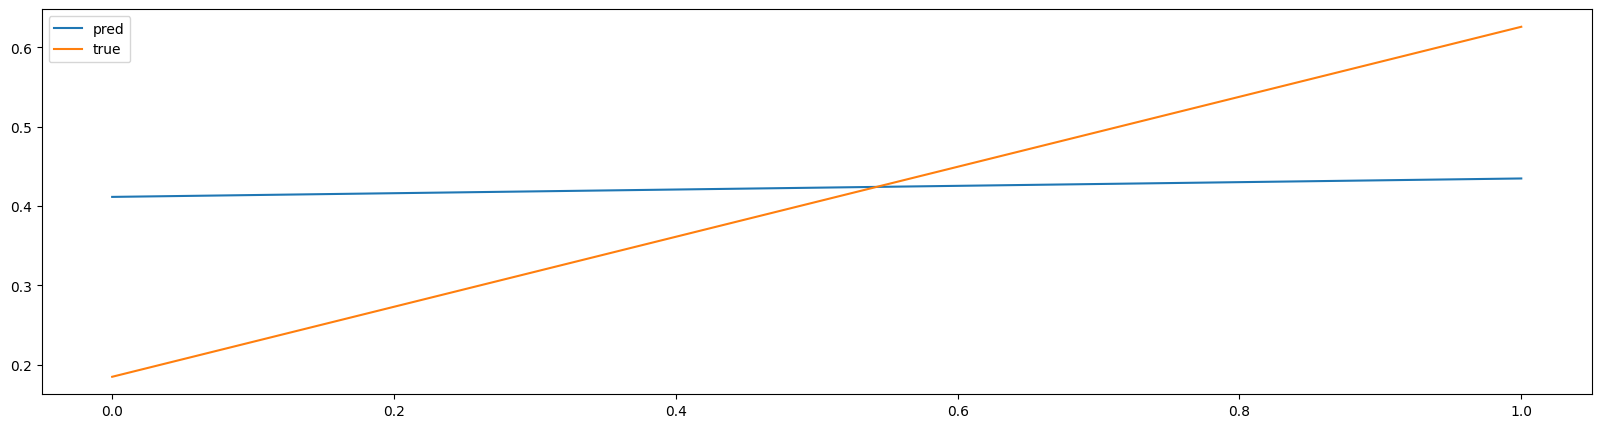

In [71]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(20,5))
sns.lineplot(data=preds, label="pred")
sns.lineplot(data=labs, label="true")